In [1]:
import mpramnist
from mpramnist.Evfratov.dataset import EvfratovDataset

from mpramnist.models import HumanLegNet
from mpramnist.models import initialize_weights
#from mpramnist.trainers import LitModel_Evfratov

import mpramnist.transforms as t
import mpramnist.target_transforms as t_t

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [2]:
BATCH_SIZE = 32
NUM_WORKERS = 103

## Some info

The dataset has a pair of attributes:

merge_last_classes — determines whether the last two classes should be merged into one.

length_of_seq — determines which dataset to use. "23" refers to the dataset with sequences of length 23, and "33" refers to the dataset with sequences of length 33. The default is "23".

## Define set of transforms

In [3]:
# preprocessing
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.ReverseComplement(0.5),
])

test_transform = t.Compose([ # test transforms are slightly different.
    t.Seq2Tensor(), 
    t.ReverseComplement(0), # Reverse complementary transformation for all sequences with a probability of 0
])

## Merging last 2 classes

### 8 classes

The data initially has 8 labels. 

You can train the model on all 8 classes, but the number of instances in the last class is extremely small. 

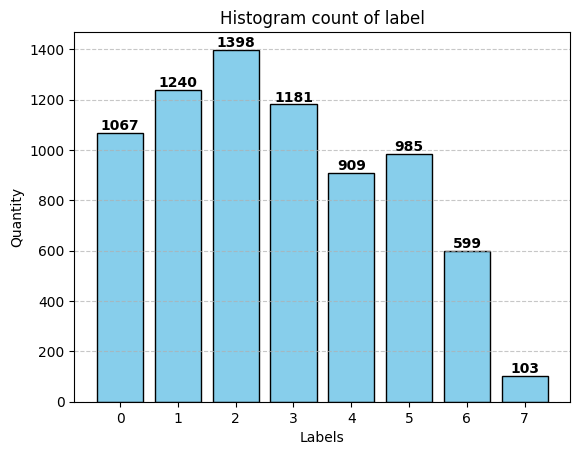

In [4]:
merge_last_classes = False

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                              transform=train_transform) # use "train" for default training set
train_dataset.hist_plot()

Therefore, to balance class representation, we propose merging the last two classes into one.

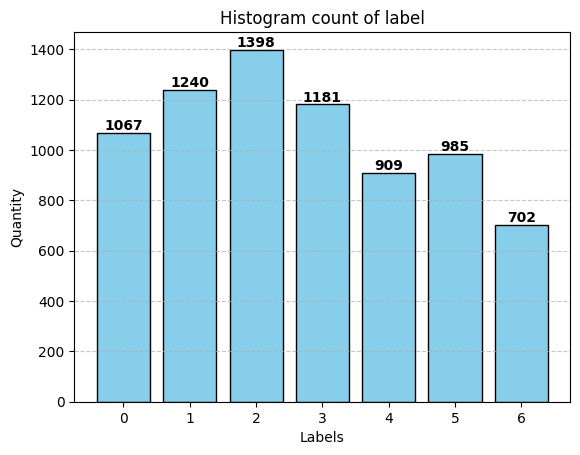

In [5]:
merge_last_classes = True

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                              transform=train_transform) # use "train" for default training set
train_dataset.hist_plot()

## First, Lets work with sequences length of 23

The default value of *length_of_seq* is 23

In [6]:
length_of_seq = 23
train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                              transform=train_transform) # use "train" for default training set
val_dataset = EvfratovDataset(split="val", merge_last_classes = merge_last_classes,
                            transform=test_transform) # use "val" for default validation set 
test_dataset = EvfratovDataset(split="test", merge_last_classes = merge_last_classes,
                             transform=test_transform) # use "test" for default test set

In [7]:
N_CLASSES = train_dataset.n_classes
in_channels = len(train_dataset[0][0])

In [8]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score

from sklearn.preprocessing import label_binarize
from itertools import cycle

def calculate_auroc(y_score, y_true, n_classes, ax=None):

    y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
    y_true = y_true.cpu().numpy()

    y = label_binarize(y_true, classes=np.arange(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    lw = 1
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:,i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = ['orange', 'green', 'red', 'purple', 'brown', 'pink', 'blue', 'yellow', 'cyan']
    colors = cycle(colors[:n_classes])
    
    # Plot of a ROC curve for a specific class
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw= 0.5,label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic for multi-class data')
    ax.legend(loc="lower right")

    return roc_auc_score(
        y_true,
        y_score,
        multi_class="ovr",
        average="macro",
    )

def calculate_aupr(y_score, y_true, n_classes, ax=None):
    y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
    y_pred = np.argmax(y_score, axis=1)
    y_true = y_true.cpu().numpy()
    
    df = pd.DataFrame({"predicted" : y_pred})
    
    ax.bar(np.arange(n_classes), np.bincount(y_pred, minlength=n_classes), color='skyblue', edgecolor='black')
    for i, count in enumerate(np.bincount(y_pred, minlength=n_classes)):
        ax.text(i, count, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Labels')
    ax.set_ylabel('Quantity')
    ax.set_title('Histogram count of label')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro')  
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    pr_auc = average_precision_score(y_true_bin, y_score, average="macro")
    return precision, recall, accuracy, f1, pr_auc
    
def roc_auc(seq_model, loader, n_classes, figure=False):
    
    predictions = trainer.predict(seq_model, dataloaders=loader)
    
    targets = torch.cat([pred["y"] for pred in predictions])
    y_preds = torch.cat([pred["pred"] for pred in predictions])

    if figure:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    auroc = calculate_auroc(y_preds, targets, n_classes, ax1 if figure else None) 
    precision, recall, accuracy, f1, aupr = calculate_aupr(y_preds, targets, n_classes, ax2 if figure else None) 
    
    res_str = '|' + ' {}: {:.5f} |'.format("Precision", precision)
    res_str += ' {}: {:.5f} |'.format("Recall", recall)
    res_str += ' {}: {:.5f} |'.format("Accuracy", accuracy)
    res_str += ' {}: {:.5f} |'.format("F1", f1)
    
    border = '-'*100
    print("\n".join(['',border, res_str, border,'']))
    
    print("Test AUROC: %.4f"%(np.nanmean(auroc)))
    print("Test AUPR: %.4f"%(np.nanmean(aupr)))

    if figure:
        plt.tight_layout()
        plt.show()

# Trainer

TODO LitModel_Evfratov

In [9]:
import pytorch_lightning as L
from torch.nn import functional as F
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
    
class Seq1Model(L.LightningModule):
    
    def __init__(self, in_ch, out_ch, lr=3e-4):
        super().__init__()
        
        self.model = HumanLegNet(in_ch=in_ch,
                                 output_dim = out_ch,
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[80, 96, 112, 128],
                                 pool_sizes=[2,2,2,2],
                                 resize_factor=4)
        self.model.apply(initialize_weights)
        

        self.loss = torch.nn.CrossEntropyLoss().to(device)
        self.lr = lr
        self.n_classes = out_ch

        self.val_loss = torch.tensor([], device=device)
        self.y_score = torch.tensor([], device=device)
        self.y_true = torch.tensor([], device=device)
        self.train_loss = torch.tensor([], device=device)

        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        X, y = batch
        y_hat = self.model(X)
        y = y.long()

        loss = self.loss(y_hat, y)
        
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        self.train_loss = torch.cat([self.train_loss, loss.unsqueeze(0)])
        
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        y = y.long()

        loss = self.loss(y_hat, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        self.val_loss = torch.cat([self.val_loss, loss.unsqueeze(0)])
        self.y_score = torch.cat([self.y_score, y_hat])
        self.y_true = torch.cat([self.y_true, y])
        
    def on_validation_epoch_end(self):
        
        val_loss = self.val_loss.mean()
        
        auroc = self.calculate_auroc(y_score=self.y_score, y_true=self.y_true, n_classes=self.n_classes) 
        arr, precision, recall, accuracy, f1, aupr = self.calculate_aupr(y_score=self.y_score, y_true=self.y_true, n_classes=self.n_classes) 
        
        res_str = '|' + ' {}: {:.5f} |'.format("Current_epoch", self.current_epoch) 
        res_str += ' {}: {:.5f} |'.format("Val_loss", val_loss)
        res_str += ' {}: {:.5f} |'.format("Val_AUCROC", auroc)
        res_str += ' {}: {:.5f} |'.format("Val_AUPR", aupr)
        res_str += "\n"
        res_str += "|"
        res_str += ' {}: {} |'.format("Number of predicted values", arr)
        res_str += "\n"
        res_str += "|"
        res_str += ' {}: {:.5f} |'.format("Precision", precision)
        res_str += ' {}: {:.5f} |'.format("Recall", recall)
        res_str += ' {}: {:.5f} |'.format("Accuracy", accuracy)
        res_str += ' {}: {:.5f} |'.format("F1", f1)
        if len(self.train_loss) != 0: 
            train_loss = self.train_loss.mean()
            res_str += ' {}: {:.5f} |'.format("Train_loss", train_loss)
            self.train_loss = torch.tensor([], device=device)
        
        border = '-'*100
        print("\n".join(['',border, res_str, border,'']))
        
        self.val_loss = torch.tensor([], device=device)
        self.y_score = torch.tensor([], device=device)
        self.y_true = torch.tensor([], device=device)

        return None

    def test_step(self, batch, _):
        x, y = batch
        y_hat = self.model(x)
        y = y.long()

        loss = self.loss(y_hat, y)
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)

    def calculate_auroc(self, y_score, y_true, n_classes):
        y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
        y_true = y_true.cpu().numpy()

        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        
        return roc_auc_score(y_true_bin, y_score, multi_class="ovr", average="macro")

    def calculate_aupr(self, y_score, y_true, n_classes):
        y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
        y_pred = np.argmax(y_score, axis=1)
        y_true = y_true.cpu().numpy()
        
        arr = []
        for i in range(n_classes):
            arr.append(y_pred.tolist().count(i))
        
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division = 0)  
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')

        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        pr_auc = average_precision_score(y_true_bin, y_score, average="macro")
        return arr, precision, recall, accuracy, f1, pr_auc

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)          
        
        return {"y": y.squeeze().long().cpu().detach().float(), "pred": y_hat.cpu().detach().float()}

    def train_dataloader(self):
        return data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS, pin_memory=True)

    def val_dataloader(self):
        return data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS, pin_memory=True)
    
    def test_dataloader(self):
        return data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS, pin_memory=True)

    def configure_optimizers(self):
        
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 1e-2)
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        return [self.optimizer], [lr_scheduler_config]


# Training

In [29]:
seq_model = Seq1Model(in_ch = in_channels, out_ch = N_CLASSES, lr = 1e-2)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
)

# Train the model
trainer.fit(seq_model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | HumanLegNet      | 1.3 M  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.296     Total estimated model params size (MB)
117       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 0.00000 | Val_loss: 1.94629 | Val_AUCROC: 0.46863 | Val_AUPR: 0.18005 |
| Number of predicted values: [9, 34, 0, 0, 0, 21, 0] |
| Precision: 0.02781 | Recall: 0.11786 | Accuracy: 0.09375 | F1: 0.04500 |
----------------------------------------------------------------------------------------------------



Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 0.00000 | Val_loss: 1.87648 | Val_AUCROC: 0.73157 | Val_AUPR: 0.28825 |
| Number of predicted values: [155, 0, 858, 3, 59, 229, 567] |
| Precision: 0.16095 | Recall: 0.26565 | Accuracy: 0.25120 | F1: 0.17510 | Train_loss: 1.74562 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 1.00000 | Val_loss: 1.48698 | Val_AUCROC: 0.79942 | Val_AUPR: 0.38410 |
| Number of predicted values: [466, 216, 220, 390, 166, 10, 403] |
| Precision: 0.37161 | Recall: 0.39247 | Accuracy: 0.36772 | F1: 0.33188 | Train_loss: 1.62347 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 2.00000 | Val_loss: 1.38194 | Val_AUCROC: 0.82724 | Val_AUPR: 0.41095 |
| Number of predicted values: [362, 100, 684, 161, 187, 289, 88] |
| Precision: 0.43289 | Recall: 0.39938 | Accuracy: 0.40246 | F1: 0.38144 | Train_loss: 1.48641 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 3.00000 | Val_loss: 1.25259 | Val_AUCROC: 0.85668 | Val_AUPR: 0.47514 |
| Number of predicted values: [273, 390, 357, 355, 86, 300, 110] |
| Precision: 0.50078 | Recall: 0.46661 | Accuracy: 0.47034 | F1: 0.46718 | Train_loss: 1.36223 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=5` reached.



----------------------------------------------------------------------------------------------------
| Current_epoch: 4.00000 | Val_loss: 1.23213 | Val_AUCROC: 0.86121 | Val_AUPR: 0.49302 |
| Number of predicted values: [340, 327, 379, 287, 167, 262, 109] |
| Precision: 0.50354 | Recall: 0.47826 | Accuracy: 0.47728 | F1: 0.48231 | Train_loss: 1.25083 |
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Precision: 0.50042 | Recall: 0.47972 | Accuracy: 0.47926 | F1: 0.48476 |
----------------------------------------------------------------------------------------------------

Test AUROC: 0.8546
Test AUPR: 0.4844


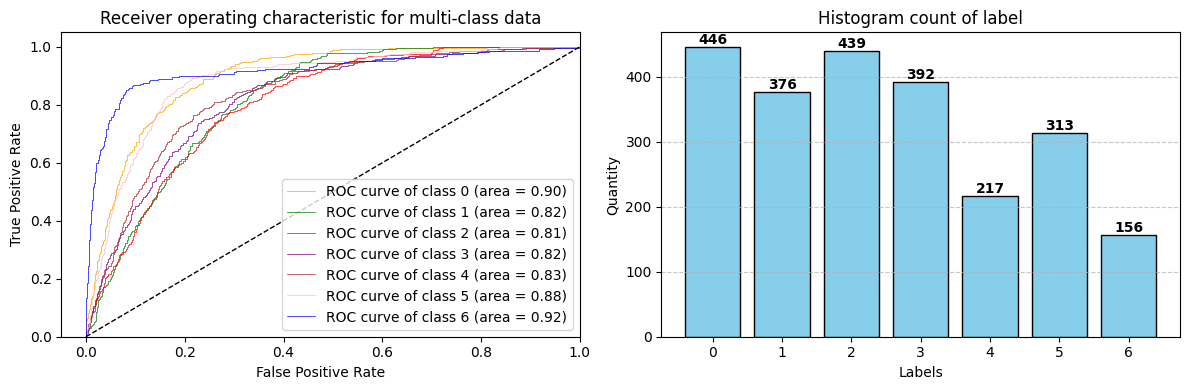

In [30]:
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
roc_auc(seq_model, test_loader, n_classes = N_CLASSES, figure = True)

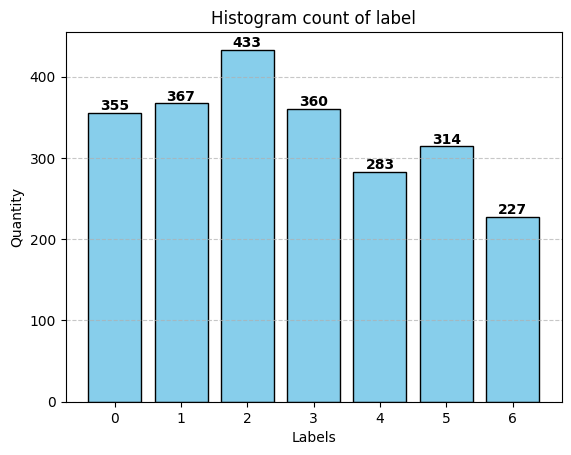

In [31]:
test_dataset.hist_plot()

## Second, Lets try with sequences length of 33

In [32]:
length_of_seq = 33
merge_last_classes = False

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes, 
                                length_of_seq = length_of_seq,
                              transform=train_transform) 
val_dataset = EvfratovDataset(split="val", merge_last_classes = merge_last_classes,
                              length_of_seq = length_of_seq,
                            transform=test_transform) 
test_dataset = EvfratovDataset(split="test", merge_last_classes = merge_last_classes,
                               length_of_seq = length_of_seq,
                             transform=test_transform) 

N_CLASSES = train_dataset.n_classes
in_channels = len(train_dataset[0][0])

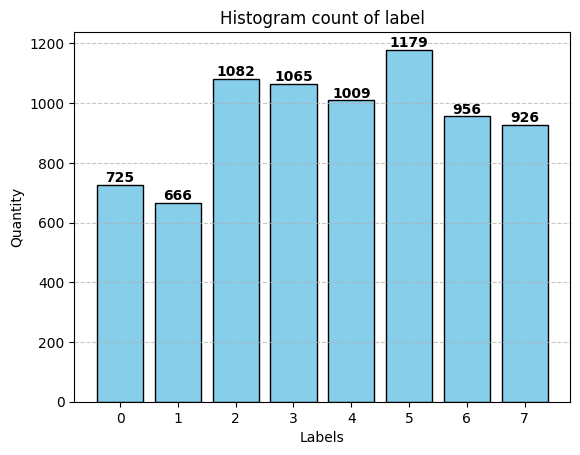

In [33]:
train_dataset.hist_plot()

# Training

In [34]:
seq_model = Seq1Model(in_ch = in_channels, out_ch = N_CLASSES, lr = 1e-2)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=15,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0
)

# Train the model
trainer.fit(seq_model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | HumanLegNet      | 1.3 M  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.297     Total estimated model params size (MB)
117       Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 0.00000 | Val_loss: 1.87951 | Val_AUCROC: 0.72319 | Val_AUPR: 0.25679 |
| Number of predicted values: [428, 53, 186, 54, 105, 285, 1, 791] |
| Precision: 0.19498 | Recall: 0.26281 | Accuracy: 0.24908 | F1: 0.18424 | Train_loss: 1.90796 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 1.00000 | Val_loss: 1.82182 | Val_AUCROC: 0.73275 | Val_AUPR: 0.26382 |
| Number of predicted values: [137, 5, 755, 0, 40, 422, 5, 539] |
| Precision: 0.19945 | Recall: 0.24135 | Accuracy: 0.24803 | F1: 0.16068 | Train_loss: 1.81724 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 2.00000 | Val_loss: 1.69045 | Val_AUCROC: 0.76140 | Val_AUPR: 0.29290 |
| Number of predicted values: [236, 0, 325, 427, 0, 485, 249, 181] |
| Precision: 0.26739 | Recall: 0.31534 | Accuracy: 0.32160 | F1: 0.28328 | Train_loss: 1.77476 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 3.00000 | Val_loss: 1.80698 | Val_AUCROC: 0.76425 | Val_AUPR: 0.29358 |
| Number of predicted values: [0, 525, 179, 544, 0, 358, 288, 9] |
| Precision: 0.15398 | Recall: 0.24065 | Accuracy: 0.23594 | F1: 0.17719 | Train_loss: 1.72594 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 4.00000 | Val_loss: 1.64159 | Val_AUCROC: 0.78375 | Val_AUPR: 0.33409 |
| Number of predicted values: [245, 0, 294, 262, 195, 539, 0, 368] |
| Precision: 0.25557 | Recall: 0.33513 | Accuracy: 0.33841 | F1: 0.28315 | Train_loss: 1.66116 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 5.00000 | Val_loss: 1.58234 | Val_AUCROC: 0.80330 | Val_AUPR: 0.34646 |
| Number of predicted values: [159, 0, 475, 108, 175, 439, 260, 287] |
| Precision: 0.31594 | Recall: 0.34840 | Accuracy: 0.35208 | F1: 0.31741 | Train_loss: 1.58829 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 6.00000 | Val_loss: 1.51576 | Val_AUCROC: 0.83156 | Val_AUPR: 0.39621 |
| Number of predicted values: [215, 0, 614, 69, 190, 135, 319, 361] |
| Precision: 0.32321 | Recall: 0.36785 | Accuracy: 0.36521 | F1: 0.31729 | Train_loss: 1.54874 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 7.00000 | Val_loss: 1.44391 | Val_AUCROC: 0.84030 | Val_AUPR: 0.40832 |
| Number of predicted values: [302, 0, 270, 398, 22, 525, 102, 284] |
| Precision: 0.35297 | Recall: 0.39991 | Accuracy: 0.40410 | F1: 0.34142 | Train_loss: 1.49711 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 8.00000 | Val_loss: 1.48807 | Val_AUCROC: 0.83096 | Val_AUPR: 0.38617 |
| Number of predicted values: [180, 53, 333, 200, 277, 404, 22, 434] |
| Precision: 0.35679 | Recall: 0.38100 | Accuracy: 0.38308 | F1: 0.34026 | Train_loss: 1.45944 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 9.00000 | Val_loss: 1.40341 | Val_AUCROC: 0.84652 | Val_AUPR: 0.41353 |
| Number of predicted values: [263, 33, 415, 200, 204, 409, 115, 264] |
| Precision: 0.39947 | Recall: 0.41529 | Accuracy: 0.41724 | F1: 0.38473 | Train_loss: 1.40947 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 10.00000 | Val_loss: 1.40182 | Val_AUCROC: 0.84651 | Val_AUPR: 0.40954 |
| Number of predicted values: [297, 0, 305, 354, 147, 462, 122, 216] |
| Precision: 0.35987 | Recall: 0.39819 | Accuracy: 0.40252 | F1: 0.36290 | Train_loss: 1.34947 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 11.00000 | Val_loss: 1.38681 | Val_AUCROC: 0.85073 | Val_AUPR: 0.42324 |
| Number of predicted values: [201, 53, 381, 266, 198, 408, 171, 225] |
| Precision: 0.42494 | Recall: 0.41505 | Accuracy: 0.41881 | F1: 0.40523 | Train_loss: 1.28279 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 12.00000 | Val_loss: 1.37957 | Val_AUCROC: 0.85703 | Val_AUPR: 0.44005 |
| Number of predicted values: [186, 102, 350, 250, 208, 355, 206, 246] |
| Precision: 0.43308 | Recall: 0.43100 | Accuracy: 0.43142 | F1: 0.42632 | Train_loss: 1.19016 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 13.00000 | Val_loss: 1.39302 | Val_AUCROC: 0.85613 | Val_AUPR: 0.43651 |
| Number of predicted values: [217, 104, 369, 243, 235, 341, 191, 203] |
| Precision: 0.43297 | Recall: 0.43007 | Accuracy: 0.42932 | F1: 0.42504 | Train_loss: 1.12799 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=15` reached.



----------------------------------------------------------------------------------------------------
| Current_epoch: 14.00000 | Val_loss: 1.38885 | Val_AUCROC: 0.85641 | Val_AUPR: 0.43533 |
| Number of predicted values: [202, 99, 369, 244, 241, 344, 202, 202] |
| Precision: 0.43453 | Recall: 0.42785 | Accuracy: 0.42827 | F1: 0.42487 | Train_loss: 1.06987 |
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Precision: 0.45009 | Recall: 0.43759 | Accuracy: 0.44029 | F1: 0.43894 |
----------------------------------------------------------------------------------------------------

Test AUROC: 0.8534
Test AUPR: 0.4351


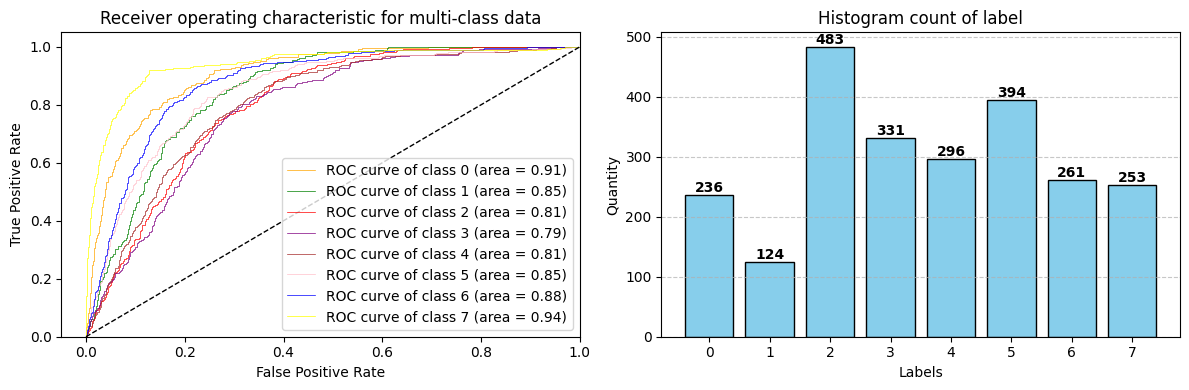

In [35]:
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
roc_auc(seq_model, test_loader, n_classes = N_CLASSES, figure = True)

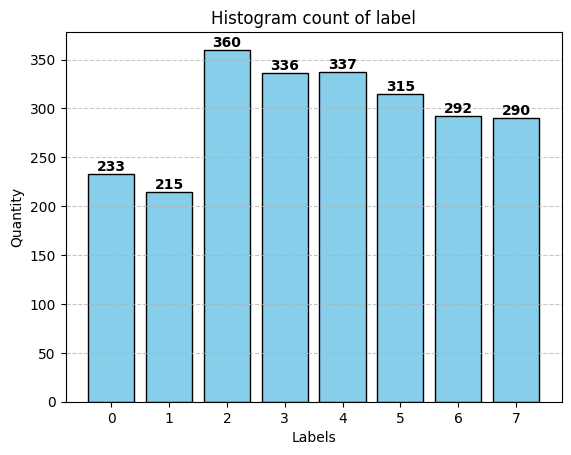

In [36]:
test_dataset.hist_plot()